In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse

# Constructing hypergraphs and corresponding comparison graphs

In [2]:
# We want the nonzero rows of W and R to sum to 1 
def row_normalize(X):
    Y = np.matrix.copy(X)
    for i in range(len(Y)):
        row = Y[i]
        row_sum = np.sum(row)
        if row_sum != 0:
            Y[i] = Y[i]/row_sum   
    return Y

In [3]:
# E: number of users
# V: number of items
# p: chance certain user watches certain movie
# e1: chance edge weight is flipped
# e2: chance user rating is flipped
# e3: chance user rating is erased
def make_hypergraphs(E, V, p, e1, e2, e3, random_seed):
    np.random.seed(random_seed)
    
    n = int(E/3)
    m = int(V/3)
    
    W = np.random.rand(V, E) # hyperedge-weight matrix, |V| x |E|, each row corresponds to a movie. 
    num_pairs = 0

    for i in range(V):
        for j in range(E):
            if W[i][j] < p:
                W[i][j] = 1

                num_pairs += 1
            else:
                W[i][j] = 0
                
    given_R = np.zeros((E, V)) # edge-dependent vertex-weight matrix, |E| x |V|, each row corresponds to a user.
    true_R = np.zeros((E, V)) # true ratings

    for i in range(V):
        for j in range(E):
            if W[i][j] == 1:
                if i // n == j // m:
                    true_R[j][i] = 5
                else:
                    true_R[j][i] = 1

                err = np.random.rand(1)
                if err < e2:
                    given_R[j][i] = 6 - true_R[j][i]
                elif err >= e2 and err < e2 + e3:
                    W[i][j] == 0
                    # do nothing as R[j][i] is already 0
                else:
                    given_R[j][i] = true_R[j][i]
                    
                    
    W1 = np.zeros((V+E, num_pairs+3)) # hyperedge weight matrix, weights are ratings x 10 IF user likes category
    W2 = np.zeros((V+E, num_pairs+3)) # otherwise 1
    W3 = np.zeros((V+E, num_pairs+3))                            

    R = np.zeros((num_pairs+3, V+E)) # edge-dependent vertex weight matrix, weights are 1

    curr_edge_index = 0 

    for i in range(V):
        for j in range(E):
            if given_R[j][i] != 0:
                # movie index = i
                # user index = V+j

                R[curr_edge_index][V+j] = 1
                R[curr_edge_index][i] = 1

                W1[V+j][curr_edge_index] = given_R[j][i]
                W1[i][curr_edge_index] = given_R[j][i]
                
                W2[V+j][curr_edge_index] = given_R[j][i]
                W2[i][curr_edge_index] = given_R[j][i]

                W3[V+j][curr_edge_index] = given_R[j][i]
                W3[i][curr_edge_index] = given_R[j][i]

                curr_edge_index += 1
    
    for i in range(V):
        if i < m:
            W1[i][num_pairs] = 100
            W2[i][num_pairs] = 1
            W3[i][num_pairs] = 1
            R[num_pairs][i] = 1
        elif i < 2 * m and i >= m:
            W1[i][num_pairs+1] = 1
            W2[i][num_pairs+1] = 100
            W3[i][num_pairs+1] = 1
            R[num_pairs+1][i] = 1
        elif i >= 2 * m:
            W1[i][num_pairs+2] = 1
            W2[i][num_pairs+2] = 1
            W3[i][num_pairs+2] = 100
            R[num_pairs+2][i] = 1
                
    for j in range(E):
        if j < n:
            W1[V+j][num_pairs] = 100
            W2[V+j][num_pairs] = 1
            W3[V+j][num_pairs] = 1
            R[num_pairs][i] = 1
        elif i < 2 * m and i >= m:
            W1[V+j][num_pairs+1] = 1
            W2[V+j][num_pairs+1] = 100
            W3[V+j][num_pairs+1] = 1
            R[num_pairs+1][V+j] = 1
        elif i >= 2 * m:
            W1[V+j][num_pairs+2] = 1
            W2[V+j][num_pairs+2] = 1
            W3[V+j][num_pairs+2] = 100
            R[num_pairs+2][V+j] = 1
                
    W1s = sparse.csr_matrix(row_normalize(W1))
    W2s = sparse.csr_matrix(row_normalize(W2))
    W3s = sparse.csr_matrix(row_normalize(W3))
    Rs = sparse.csr_matrix(row_normalize(R))

    # create prob trans matrices
    P1 = np.transpose(W1s.dot(Rs))
    P2 = np.transpose(W2s.dot(Rs))
    P3 = np.transpose(W3s.dot(Rs))

    return P1, P2, P3, R, given_R, true_R

# Computing personalized PageRank rankings

In [4]:
# given probability transition matrix P
# where P_{v,w} = Prob(w -> v)
# find pagerank scores with restart probability r
def compute_pr(P, r, n, home, eps=1e-8):
    
    x = np.ones(n) / n*1.0

    flag = True
    t=0
        
    while flag:
        x_new = (1-r)*P*x

        x_new = x_new + home * r 
        
        if np.linalg.norm(x_new - x,ord=1) < eps and t > 100:
            flag = False
        t=t+1
        x = x_new
    
    return x

In [5]:
def get_rankings(E, V, R, P1, P2, P3, r):
    
    rankings_hg = np.zeros((E, V)) # each row corresponds to a user. 
    n = int(E/3)
    
    for i in range(E):

        if i < n:
            P = P1
        elif i < 2 * n:
            P = P2
        else: 
            P = P3

        # personalize the algorithm by restarting at any of the movies a certain user originally watched

        home_hg = np.zeros(V+E)
        home_hg[V+i] = 1

        curr_rankings_hg = compute_pr(P, r, V+E, home_hg).flatten()
        rankings_hg[i,:] = curr_rankings_hg[:V]
        
    return rankings_hg

# Evaluating rankings

In [6]:
# Source: https://www.aaai.org/Papers/IJCAI/2007/IJCAI07-444.pdf
def calc_avg_doa(num_users, num_movies, ratings, rankings):
    
    n = num_users/3
    m = num_movies/3
    
    total_pairs = 0
    correct_pairs = 0
    
    # All pairs of movies. 
    for i in range(num_movies):
        for j in range(i+1, num_movies):
            for user in range(num_users):

                if i // m != j // m:
                    if user // n == i // m:
                        total_pairs += 1
                        if rankings[user][i] > rankings[user][j]:
                            correct_pairs += 1
                    elif user // n == j // m:
                        total_pairs += 1
                        if rankings[user][i] < rankings[user][j]:
                            correct_pairs += 1
       
    if total_pairs == 0:
        return -1
    return correct_pairs/total_pairs

def calc_avg_udoa(num_users, num_movies, ratings, rankings):
    
    n = num_users/3
    m = num_movies/3
    
    total_pairs = 0
    correct_pairs = 0
    
    # All pairs of movies. 
    for i in range(num_movies):
        for j in range(i+1, num_movies):
            for user in range(num_users):
                
                if ratings[user][i] == 0 and ratings[user][j] == 0:
                    if i // m != j // m:
                        if user // n == i // m:
                            total_pairs += 1
                            if rankings[user][i] > rankings[user][j]:
                                correct_pairs += 1
                        elif user // n == j // m:
                            total_pairs += 1
                            if rankings[user][i] < rankings[user][j]:
                                correct_pairs += 1
       
    if total_pairs == 0:
        return -1
    return correct_pairs/total_pairs

In [7]:
def do_everything(E, V, p, e1, e2, e3, random_seed):
    
    n = int(E/3)
    m = int(V/3)
    
    P1, P2, P3, R, given_R, true_R = make_hypergraphs(E, V, p, e1, e2, e3, random_seed)

    rankings_hg = get_rankings(E, V, R, P1, P2, P3, 0.15)
    
    avgdoa = calc_avg_doa(E, V, true_R, rankings_hg)
  
    avgudoa = calc_avg_udoa(E, V, true_R, rankings_hg)

    return avgdoa, avgudoa

In [8]:
# To remove the effects of randomness, average results generated by many random seeds. 
def do_everything_n_times(E, V, p, e1, e2, e3, n):
    print("n=%d, p=%.3f, e1=%.3f, e2=%.3f, e3=%.3f" % (n, p, e1, e2, e3))
    
    if n == 0:
        return
    
    d = 0
    ud = 0
    
    for i in range(n):
        d1, ud1 = do_everything(E, V, p, e1, e2, e3, i)
        d += d1
        ud += ud1
        
    d = d/n
    ud = ud/n

    return d, ud

# Running

In [9]:
n = 50
m = 50
    
E = 3 * n # number of "users"
V = 3 * m # number of "movies

In [10]:
probs = np.linspace(0, 1, num=11)
num_probs = len(probs)

#e1_hg = np.zeros(num_probs)
e2_hg = np.zeros(num_probs)
e3_hg = np.zeros(num_probs)

#e1_hg_u = np.zeros(num_probs)
e2_hg_u = np.zeros(num_probs)
e3_hg_u = np.zeros(num_probs)

In [11]:
d_hg, ud_hg = do_everything_n_times(E, V, 0.15, 0, 0, 0, 10)

#e1_hg[0] = d_hg
e2_hg[0] = d_hg
e3_hg[0] = d_hg

#e1_hg_u[0] = ud_hg
e2_hg_u[0] = ud_hg
e3_hg_u[0] = ud_hg

n=10, p=0.150, e1=0.000, e2=0.000, e3=0.000


In [14]:
for i in range(1, num_probs):
    prob = probs[i]
    
  #  testing e1 no longer makes sense
#    e1hg, e1hgu = do_everything_n_times(E, V, 0.15, prob, 0, 0, 10)
#    
 #   e1_hg[i] = e1hg
 #   e1_hg_u[i] = e1hgu
    
    e2hg, e2hgu = do_everything_n_times(E, V, 0.15, 0, prob, 0, 10)
    
    e2_hg[i] = e2hg
    e2_hg_u[i] = e2hgu
    
    e3hg, e3hgu = do_everything_n_times(E, V, 0.15, 0, 0, prob, 10)
    
    e3_hg[i] = e3hg
    e3_hg_u[i] = e3hgu

    print()

n=10, p=0.150, e1=0.100, e2=0.000, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.100, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.000, e3=0.100

n=10, p=0.150, e1=0.200, e2=0.000, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.200, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.000, e3=0.200

n=10, p=0.150, e1=0.300, e2=0.000, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.300, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.000, e3=0.300

n=10, p=0.150, e1=0.400, e2=0.000, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.400, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.000, e3=0.400

n=10, p=0.150, e1=0.500, e2=0.000, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.500, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.000, e3=0.500

n=10, p=0.150, e1=0.600, e2=0.000, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.600, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.000, e3=0.600

n=10, p=0.150, e1=0.700, e2=0.000, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.700, e3=0.000
n=10, p=0.150, e1=0.000, e2=0.000, e3=0.700

n=10, p=0.150, e1=0.800, e2=0.000, e3=0.000
n=10, p=0.150, e1=0.000, 

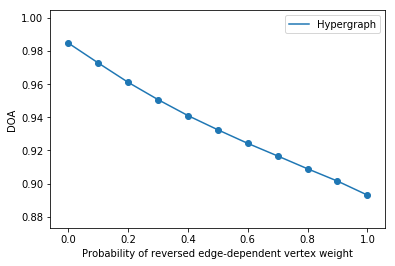

In [16]:
plt.scatter(probs, e2_hg)
plt.plot(probs, e2_hg, label='Hypergraph')
plt.legend(loc='upper right')
plt.xlabel('Probability of reversed edge-dependent vertex weight')
plt.ylabel('DOA')
plt.show()

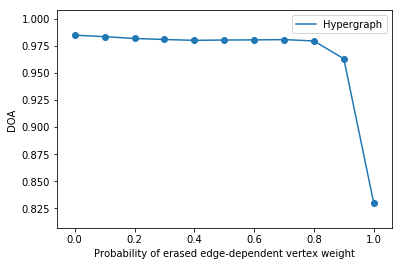

In [17]:
plt.scatter(probs, e3_hg)
plt.plot(probs, e3_hg, label='Hypergraph')
plt.legend(loc='upper right')
plt.xlabel('Probability of erased edge-dependent vertex weight')
plt.ylabel('DOA')
plt.show()

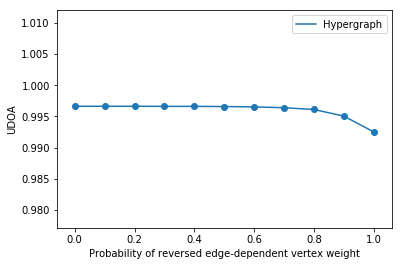

In [19]:
plt.scatter(probs, e2_hg_u)
plt.plot(probs, e2_hg_u, label='Hypergraph')
plt.legend(loc='upper right')
plt.xlabel('Probability of reversed edge-dependent vertex weight')
plt.ylabel('UDOA')
plt.show()

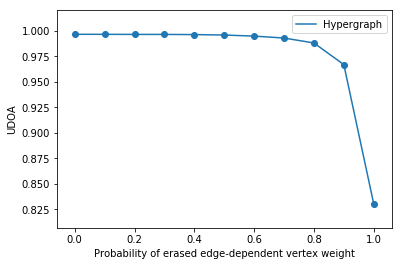

In [20]:
plt.scatter(probs, e3_hg_u)
plt.plot(probs, e3_hg_u, label='Hypergraph')
plt.legend(loc='upper right')
plt.xlabel('Probability of erased edge-dependent vertex weight')
plt.ylabel('UDOA')
plt.show()